# DeepLabV3 Semantic Segmentation - Basic Example

This notebook demonstrates how to use a pre-trained DeepLabV3 model for semantic segmentation tasks. DeepLabV3 is a state-of-the-art deep learning architecture for semantic segmentation that can classify each pixel in an image into different categories.

## What we'll cover:
1. Loading a pre-trained DeepLabV3 model
2. Image preprocessing and data preparation
3. Running inference on input images
4. Visualizing segmentation results
5. Applying color maps to segmentation masks
6. Saving the output results

## 1. Import Required Libraries

First, let's import all the necessary libraries for this example.

In [32]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib to display plots inline
plt.rcParams['figure.figsize'] = [12, 8]

Using device: cpu


## 2. Load Pre-trained DeepLabV3 Model

We'll load a pre-trained DeepLabV3 model with a ResNet-101 backbone that was trained on the COCO dataset.

In [33]:
# Load pre-trained DeepLabV3 model
print("Loading pre-trained DeepLabV3 model...")
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Number of classes: {model.classifier[-1].out_channels}")

Loading pre-trained DeepLabV3 model...
Model loaded successfully!
Number of classes: 21
Model loaded successfully!
Number of classes: 21


## 3. Load and Preprocess Input Image

Let's load a sample image and preprocess it for the DeepLabV3 model. We'll download a sample image from the internet, but you can replace this with your own image path.

Local image '4.jpg' loaded successfully!
Original image size: (1024, 649)
Input tensor shape: torch.Size([1, 3, 520, 520])


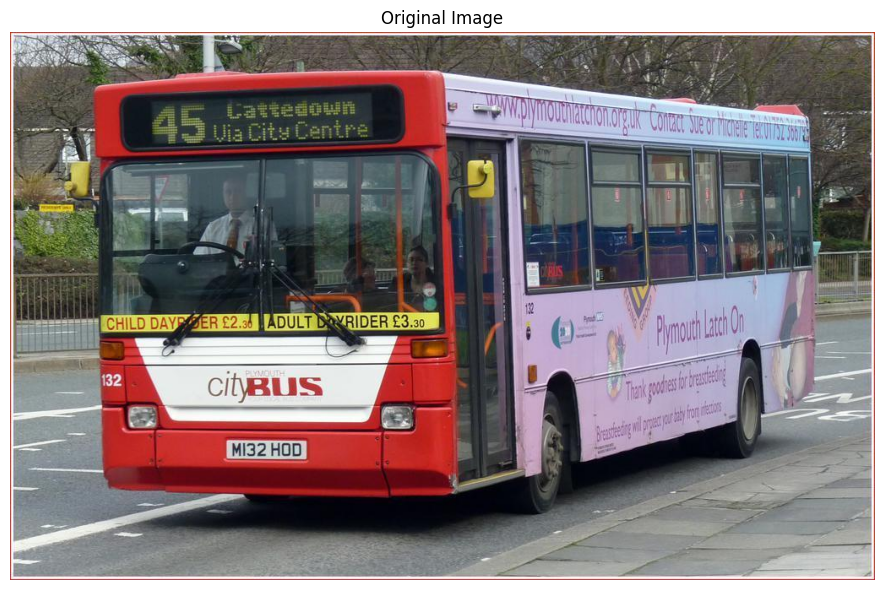

In [34]:
# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((520, 520)),  # Resize to a standard size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load a local image file
def load_sample_image():
    # Local image path
    image_path = "4.jpg"
    
    try:
        img = Image.open(image_path).convert('RGB')
        print(f"Local image '{image_path}' loaded successfully!")
    except FileNotFoundError:
        print(f"Error: Image file '{image_path}' not found!")
        print("Please make sure '1.jpg' exists in the current directory.")
        print("Creating a simple test image as fallback...")
        img_array = np.random.randint(0, 255, (400, 600, 3), dtype=np.uint8)
        img = Image.fromarray(img_array)
    except Exception as e:
        print(f"Error loading image: {e}")
        print("Creating a simple test image as fallback...")
        img_array = np.random.randint(0, 255, (400, 600, 3), dtype=np.uint8)
        img = Image.fromarray(img_array)
    
    return img

# Load and preprocess the image
original_image = load_sample_image()
input_tensor = preprocess(original_image).unsqueeze(0).to(device)

print(f"Original image size: {original_image.size}")
print(f"Input tensor shape: {input_tensor.shape}")

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Perform Semantic Segmentation

Now let's run the preprocessed image through the DeepLabV3 model to get the segmentation predictions.

In [35]:
# Perform inference
print("Running semantic segmentation inference...")
with torch.no_grad():
    output = model(input_tensor)
    
# Get the segmentation predictions
predictions = output['out']
print(f"Output shape: {predictions.shape}")

# Convert predictions to segmentation mask
segmentation_mask = torch.argmax(predictions, dim=1).squeeze().cpu().numpy()
print(f"Segmentation mask shape: {segmentation_mask.shape}")
print(f"Unique classes in mask: {np.unique(segmentation_mask)}")

print("Segmentation completed successfully!")

Running semantic segmentation inference...
Output shape: torch.Size([1, 21, 520, 520])
Segmentation mask shape: (520, 520)
Unique classes in mask: [0 6]
Segmentation completed successfully!
Output shape: torch.Size([1, 21, 520, 520])
Segmentation mask shape: (520, 520)
Unique classes in mask: [0 6]
Segmentation completed successfully!


## 5. Post-process and Visualize Results

Let's visualize the original image alongside the segmentation mask to see the results.

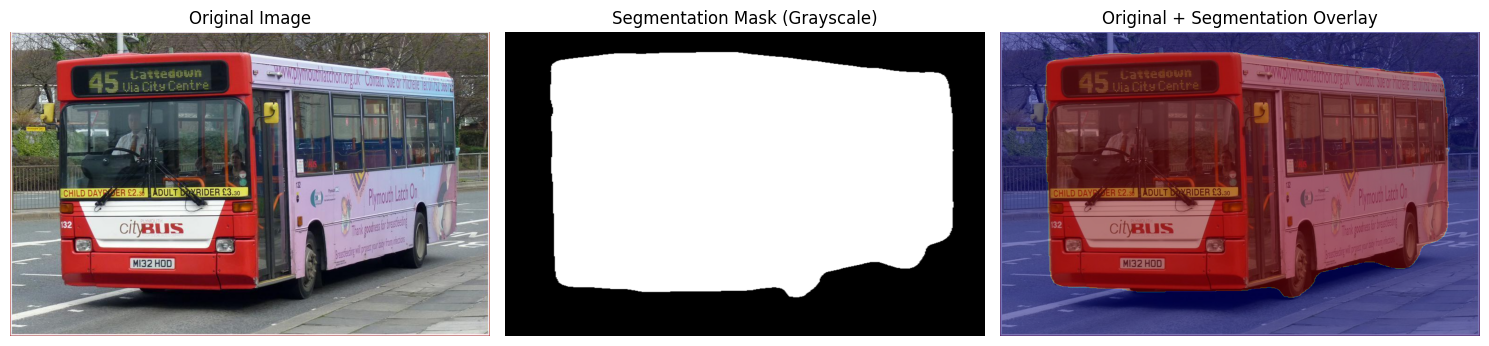

Segmentation completed! Found 7 different classes in the image.


In [36]:
# Resize the segmentation mask to match original image size
original_size = original_image.size  # (width, height)
mask_resized = np.array(Image.fromarray(segmentation_mask.astype(np.uint8)).resize(original_size))

# Visualize the results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Segmentation mask (grayscale)
plt.subplot(1, 3, 2)
plt.imshow(mask_resized, cmap='gray')
plt.title("Segmentation Mask (Grayscale)")
plt.axis('off')

# Overlay segmentation on original image
plt.subplot(1, 3, 3)
plt.imshow(original_image)
plt.imshow(mask_resized, alpha=0.5, cmap='jet')
plt.title("Original + Segmentation Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Segmentation completed! Found {len(np.unique(mask_resized))} different classes in the image.")

## 6. Focus on License Plate Vehicles

Let's create a specialized visualization that highlights only vehicles that typically have license plates (cars, motorcycles, trucks, and buses) and filters out other objects.

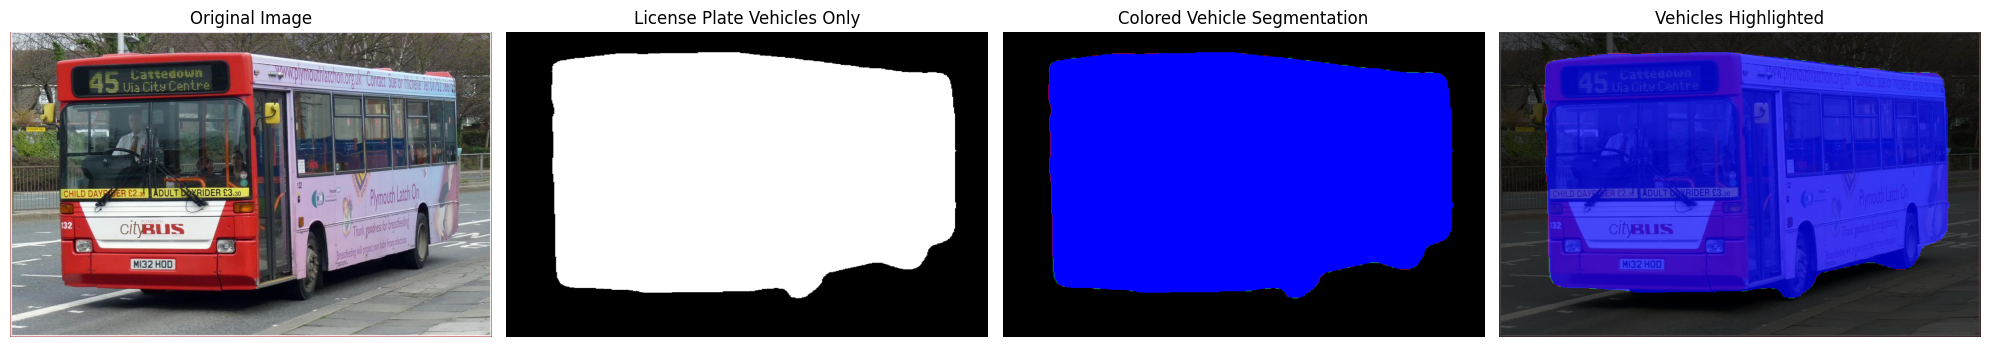

🚗 Detected License Plate Vehicles:
  ✅ Car (Class 3): 656 pixels (0.10% of image)
  ✅ Motorcycle (Class 4): 389 pixels (0.06% of image)
  ✅ Bus (Class 6): 398,786 pixels (60.01% of image)

Total vehicle classes found: 3
Legend: 🔴 Car | 🟢 Motorcycle | 🔵 Bus | 🟡 Truck


In [37]:
# COCO classes for DeepLabV3 (first 21 classes)
COCO_CLASSES = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic_light', 'fire_hydrant', 'stop_sign',
    'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow'
]

# Define vehicle classes that typically have license plates
LICENSE_PLATE_VEHICLES = {
    3: 'car',
    4: 'motorcycle', 
    6: 'bus',
    8: 'truck'
}

# Create a color palette for visualization (focusing on license plate vehicles)
def create_color_palette(num_classes=21):
    """Create a color palette for segmentation visualization"""
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    palette[0] = [0, 0, 0]  # Background is black
    
    # Assign bright colors only to license plate vehicles
    vehicle_colors = {
        3: [255, 0, 0],    # Car - Red
        4: [0, 255, 0],    # Motorcycle - Green
        6: [0, 0, 255],    # Bus - Blue
        8: [255, 255, 0]   # Truck - Yellow
    }
    
    for class_id, color in vehicle_colors.items():
        if class_id < num_classes:
            palette[class_id] = color
    
    return palette

# Apply color mapping (only highlight license plate vehicles)
def apply_color_map(mask, palette, filter_vehicles=True):
    """Apply color mapping to segmentation mask, optionally filtering for vehicles only"""
    height, width = mask.shape
    colored_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_id in np.unique(mask):
        if class_id < len(palette):
            if filter_vehicles:
                # Only color license plate vehicles
                if class_id in LICENSE_PLATE_VEHICLES:
                    colored_mask[mask == class_id] = palette[class_id]
                # Keep background black
                elif class_id == 0:
                    colored_mask[mask == class_id] = palette[class_id]
            else:
                colored_mask[mask == class_id] = palette[class_id]
    
    return colored_mask

# Create color palette and apply it (focus on license plate vehicles)
color_palette = create_color_palette()
colored_mask = apply_color_map(mask_resized, color_palette, filter_vehicles=True)

# Also create a mask that shows only license plate vehicles (binary mask)
vehicle_only_mask = np.zeros_like(mask_resized)
for class_id in LICENSE_PLATE_VEHICLES.keys():
    vehicle_only_mask[mask_resized == class_id] = class_id

# Visualize the colored segmentation
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Vehicle-only mask (grayscale)
plt.subplot(1, 4, 2)
plt.imshow(vehicle_only_mask, cmap='gray')
plt.title("License Plate Vehicles Only")
plt.axis('off')

# Colored segmentation mask (vehicles only)
plt.subplot(1, 4, 3)
plt.imshow(colored_mask)
plt.title("Colored Vehicle Segmentation")
plt.axis('off')

# Blended result (vehicles only)
plt.subplot(1, 4, 4)
blended = Image.blend(original_image, Image.fromarray(colored_mask), alpha=0.7)
plt.imshow(blended)
plt.title("Vehicles Highlighted")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print detected license plate vehicles only
detected_vehicles = []
for class_id in np.unique(mask_resized):
    if class_id in LICENSE_PLATE_VEHICLES:
        detected_vehicles.append((class_id, LICENSE_PLATE_VEHICLES[class_id]))

print("🚗 Detected License Plate Vehicles:")
if detected_vehicles:
    for class_id, vehicle_name in detected_vehicles:
        pixel_count = np.sum(mask_resized == class_id)
        percentage = (pixel_count / mask_resized.size) * 100
        print(f"  ✅ {vehicle_name.capitalize()} (Class {class_id}): {pixel_count:,} pixels ({percentage:.2f}% of image)")
else:
    print("  ❌ No license plate vehicles detected in the image")

print(f"\nTotal vehicle classes found: {len(detected_vehicles)}")
print("Legend: 🔴 Car | 🟢 Motorcycle | 🔵 Bus | 🟡 Truck")

## 7. Save Segmentation Output

Finally, let's save our results to files for future use or sharing.

In [38]:
# Create output directory
output_dir = "segmentation_results"
os.makedirs(output_dir, exist_ok=True)

# Save the original image
original_image.save(os.path.join(output_dir, "original_image.jpg"))
print("✓ Original image saved")

# Save the grayscale segmentation mask (all objects)
mask_image = Image.fromarray(mask_resized.astype(np.uint8))
mask_image.save(os.path.join(output_dir, "full_segmentation_mask.png"))
print("✓ Full segmentation mask saved")

# Save the vehicle-only mask (grayscale)
vehicle_mask_image = Image.fromarray(vehicle_only_mask.astype(np.uint8))
vehicle_mask_image.save(os.path.join(output_dir, "vehicles_only_mask.png"))
print("✓ License plate vehicles mask saved")

# Save the colored vehicle segmentation
colored_image = Image.fromarray(colored_mask)
colored_image.save(os.path.join(output_dir, "colored_vehicle_segmentation.png"))
print("✓ Colored vehicle segmentation saved")

# Save the blended result (vehicles highlighted)
blended.save(os.path.join(output_dir, "vehicles_highlighted.jpg"))
print("✓ Vehicle-highlighted result saved")

print(f"\n🚗 All results saved in the '{output_dir}' directory!")
print("Files created:")
for filename in sorted(os.listdir(output_dir)):
    print(f"  - {filename}")

# Create a summary report
vehicle_summary = {
    'total_pixels': mask_resized.size,
    'vehicles_found': detected_vehicles,
    'vehicle_pixel_count': sum(np.sum(mask_resized == class_id) for class_id, _ in detected_vehicles)
}

if vehicle_summary['vehicles_found']:
    vehicle_coverage = (vehicle_summary['vehicle_pixel_count'] / vehicle_summary['total_pixels']) * 100
    print(f"\n📊 Vehicle Detection Summary:")
    print(f"  - Total vehicles detected: {len(vehicle_summary['vehicles_found'])}")
    print(f"  - Vehicle coverage: {vehicle_coverage:.2f}% of image")
else:
    print(f"\n📊 No license plate vehicles detected in this image.")

✓ Original image saved
✓ Full segmentation mask saved
✓ License plate vehicles mask saved
✓ Colored vehicle segmentation saved
✓ Vehicle-highlighted result saved

🚗 All results saved in the 'segmentation_results' directory!
Files created:
  - colored_vehicle_segmentation.png
  - full_segmentation_mask.png
  - original_image.jpg
  - vehicles_highlighted.jpg
  - vehicles_only_mask.png

📊 Vehicle Detection Summary:
  - Total vehicles detected: 3
  - Vehicle coverage: 60.16% of image


## Conclusion

Congratulations! You have successfully run a specialized DeepLabV3 semantic segmentation example focused on detecting license plate vehicles. Here's what we accomplished:

1. ✅ Loaded a pre-trained DeepLabV3 model with ResNet-101 backbone
2. ✅ Preprocessed an input image with proper normalization
3. ✅ Performed semantic segmentation inference
4. ✅ **Filtered results to show only license plate vehicles** (cars, motorcycles, trucks, buses)
5. ✅ Created specialized visualizations highlighting vehicle detection
6. ✅ Generated detailed vehicle detection statistics
7. ✅ Saved all outputs including vehicle-specific masks

## Vehicle Classes Detected

This specialized version focuses on 4 main vehicle types that typically have license plates:

- 🔴 **Cars** (Class 3) - Red highlighting
- 🟢 **Motorcycles** (Class 4) - Green highlighting  
- 🔵 **Buses** (Class 6) - Blue highlighting
- 🟡 **Trucks** (Class 8) - Yellow highlighting

## Next Steps for Vehicle Detection

To extend this license plate vehicle detection example, you could:

- **License Plate Recognition**: Add OCR to read actual license plate text
- **Vehicle Counting**: Count vehicles crossing a line or in a region
- **Traffic Monitoring**: Analyze vehicle flow and density
- **Parking Detection**: Identify occupied vs. empty parking spaces
- **Speed Estimation**: Track vehicles across video frames
- **Vehicle Classification**: Fine-tune to detect specific vehicle sub-types
- **Real-time Traffic Analysis**: Process live camera feeds

## Useful Resources for Vehicle Detection

- [DeepLabV3 Paper](https://arxiv.org/abs/1706.05587)
- [COCO Dataset Vehicle Classes](https://cocodataset.org/)
- [Vehicle Detection Datasets](https://www.cityscapes-dataset.com/)
- [Traffic Analysis with Deep Learning](https://paperswithcode.com/task/traffic-sign-recognition)

Happy vehicle detecting! 🚗🏍️🚌🚛